# General Adversarial Networks (GANs)

Basic idea behind GANs is that there are two competing neural networks (generator network and discriminator network) that work towards opposing goals. The goal of the generator network is to fool the discriminator network into believing that the data generated by the generator network is real. 

To get a better understanding of how GANs work, we will implement GAN for a simple 1-dimensional function. Here, we will use GAN to generate a quadratic function.


In [1]:
# Importing the necessary modules
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import imageio
import glob

from IPython import display

In [2]:
# Checking the tensorflow version. The tensorflow version must be 2.x
tf.__version__

'2.3.1'

In [3]:
#defining the quadratic function that our generator model will learn
def get_y(x):
    return x*x

# defining the function to create our real dataset (x,y). x's are randomly sampled from (-scale*0.5, scale*0.5). y's are calculated using
# the get_y function defined above.
def sample_data(n=10000, scale=10):
    data = []

    #randomly sampling x from (-scale*0.5, scale*0.5)
    x = scale*(np.random.rand(n)-0.5)
    
    # finding the y value for the corresponding x's
    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    #return both x and y values
    return np.array(data)

In [4]:
# Defining the generator model
def make_generator_model():
    
    model = tf.keras.Sequential()
    
    # the generator model takes an input of shape [batch_size, 5]
    model.add(layers.Dense(25, input_shape=(5,)))
    
    model.add(layers.ReLU())
    
    # the generator model output is of the shape [batch_size, 2]
    model.add(layers.Dense(2))
    
    return model

In [5]:
# Creating an instance of the generator
generator = make_generator_model()

# the generator network works as expected
noise = tf.random.uniform(shape=[1,5],minval = -1., maxval = 1.)
generated_value = generator(noise, training=False)
print(generated_value)

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0.01897134, 0.02005003]], dtype=float32)>

In [6]:
# Defining the discriminator model
def make_discriminator_model():
    model = tf.keras.Sequential()
    
    # the discriminator model takes an input of shape [batch_size, 2]
    model.add(layers.Dense(25, input_shape=(2,)))
    
    model.add(layers.ReLU())
    
    # the discriminator model outputs the logit values of shape [batch_size, 1]
    model.add(layers.Dense(1))
    
    return model

In [7]:
# Creating an instance of the discriminator
discriminator = make_discriminator_model()

# the discriminator mnetwork works as expected
decision = discriminator(generated_value)
print(decision)

tf.Tensor([[0.01431734]], shape=(1, 1), dtype=float32)


In [8]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [9]:
# Defining the discriminator loss
def discriminator_loss(real_output, fake_output):
    
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [10]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [12]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [13]:
EPOCHS = 20000
noise_dim = 5
num_examples_to_generate = 500

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.uniform(shape=[num_examples_to_generate, noise_dim], minval = -1., maxval = 1.)

In [14]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.uniform(shape=[BATCH_SIZE, noise_dim], minval = -1., maxval = 1.)

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [15]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        
        gen_loss_vec = []
        disc_loss_vec = []
        for image_batch in dataset:
            gen_loss, disc_loss = train_step(image_batch)
            gen_loss_vec.append(gen_loss)
            disc_loss_vec.append(disc_loss)
        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_images(generator,
                        epoch + 1,
                        seed)
        
        # Save images for the GIF every 1000 epochs
        if epoch%1000==0:
            save_images(generator,
                        epoch + 1,
                        seed)

        #Save the model every 1000 epochs
        if (epoch + 1) % 1000 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print('Time for epoch {} is {} sec and gen loss is {} and disc loss is {}'.format(epoch + 1,
                                                                                        time.time()-start,
                                                                                        np.mean(gen_loss_vec),
                                                                                        np.mean(disc_loss_vec)))
        
    # Generate after the final epoch
    display.clear_output(wait=True)
    save_images(generator,
                epochs,
                seed)

In [16]:
def generate_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8,4))
    plt.scatter(dataset[0:500,0], dataset[0:500,1], label = 'real data')
    plt.scatter(predictions[:,0], predictions[:,1], label = 'fake data')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

In [17]:
def save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode.
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(8,4))
    plt.scatter(dataset[0:500,0], dataset[0:500,1], label = 'real data')
    plt.scatter(predictions[:,0], predictions[:,1], label = 'fake data')
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.savefig('./figures/1dgan/image_at_epoch_{:05d}.png'.format(epoch))
    plt.show()

In [18]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [19]:
dataset = sample_data(n=256*4, scale=10)

BATCH_SIZE = 256

train_data = tf.data.Dataset.from_tensor_slices(dataset).batch(BATCH_SIZE)

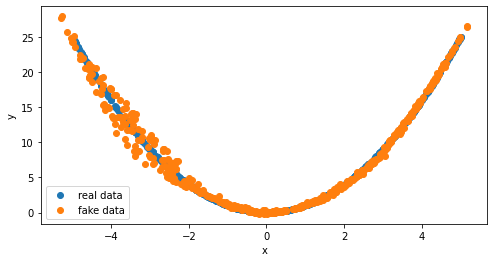

In [20]:
train(train_data, EPOCHS)

In [21]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [22]:
def display_image(epoch_no):
    return PIL.Image.open('./figures/1dgan/image_at_epoch_{:05d}.png'.format(epoch_no))

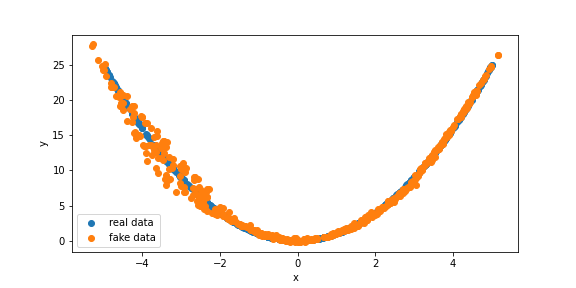

In [27]:
display_image(EPOCHS)


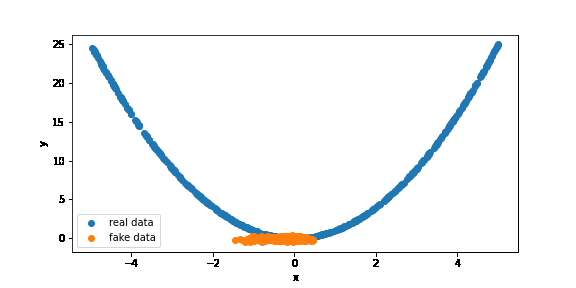

In [25]:
anim_file = './figures/1dgan/1dgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames = glob.glob('./figures/1dgan/image*.png')
    filenames = sorted(filenames)
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)
    
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)